In [1]:
import rioxarray
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rasterio

%matplotlib inline

To determine what part to get, we use the figure from [mines](https://eogdata.mines.edu/products/vnl/#monthly),

![coverage](https://eogdata.mines.edu/products/assets/img/tile_map.png)

As can be seen in the file [download directory](https://eogdata.mines.edu/nighttime_light/monthly/v10/2021/202109/vcmcfg/) the latitude and longtitude is switched around in some cases.

In [2]:
from pyalanysis.data import ViirsDnbMonthlyDataLoader, ViirsDnbMonthlyType
import os

vdl = ViirsDnbMonthlyDataLoader()

viirs = vdl.open_viirs_monthly_file(vdl.get_viirs_dnb_monthly_file("75N060W", 2021, 12, ViirsDnbMonthlyType.STRAY_LIGHT_CORRECTED))

In [3]:
# An explicit check to ensure that we have the right projection
# to allow to clip the Netherlands

if viirs.rio.crs is None: 
    viirs.rio.set_crs(rasterio.crs.CRS({"init": "EPSG:4326"}))

In [4]:
netherlands = [
    {
        'type': 'Polygon',
        'coordinates': [[
            [3.2006621064250274, 53.58584446228139],
            [3.2006621064250274, 50.69456930499138],
            [7.276589840800027, 50.69456930499138],
            [7.276589840800027, 53.58584446228139]
        ]]
    }
]

In [5]:
alan_nl = viirs[dict(band=0, time=0)].rio.clip(netherlands)
alan_nl

<xarray.Dataset>
Dimensions:      (y: 694, x: 978)
Coordinates:
  * y            (y) float64 53.58 53.58 53.57 53.57 ... 50.71 50.7 50.7 50.7
  * x            (x) float64 3.204 3.208 3.213 3.217 ... 7.263 7.267 7.271 7.275
    band         int64 1
    time         datetime64[ns] 2021-12-01
    spatial_ref  int64 0
Data variables:
    avg_rad9h    (y, x) float32 0.25 0.24 0.13 0.21 0.15 ... 1.89 2.28 2.25 3.37
    cvg          (y, x) uint16 30 30 30 30 30 30 30 30 ... 26 26 26 26 26 26 26
    cf_cvg       (y, x) uint16 4 6 6 4 4 5 5 5 5 5 5 4 ... 4 4 4 3 4 4 4 5 4 4 4
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

/var/folders/sf/t_jvygqj3cs_7m619k5d67500000gn/T/ipykernel_52927/167832636.py:5: RuntimeWarning: divide by zero encountered in log
  avg_rad9h_log = xr.apply_ufunc(lambda x: np.log(x), alan_nl['avg_rad9h'])
/var/folders/sf/t_jvygqj3cs_7m619k5d67500000gn/T/ipykernel_52927/167832636.py:5: RuntimeWarning: invalid value encountered in log
  avg_rad9h_log = xr.apply_ufunc(lambda x: np.log(x), alan_nl['avg_rad9h'])


<Figure size 432x288 with 0 Axes>

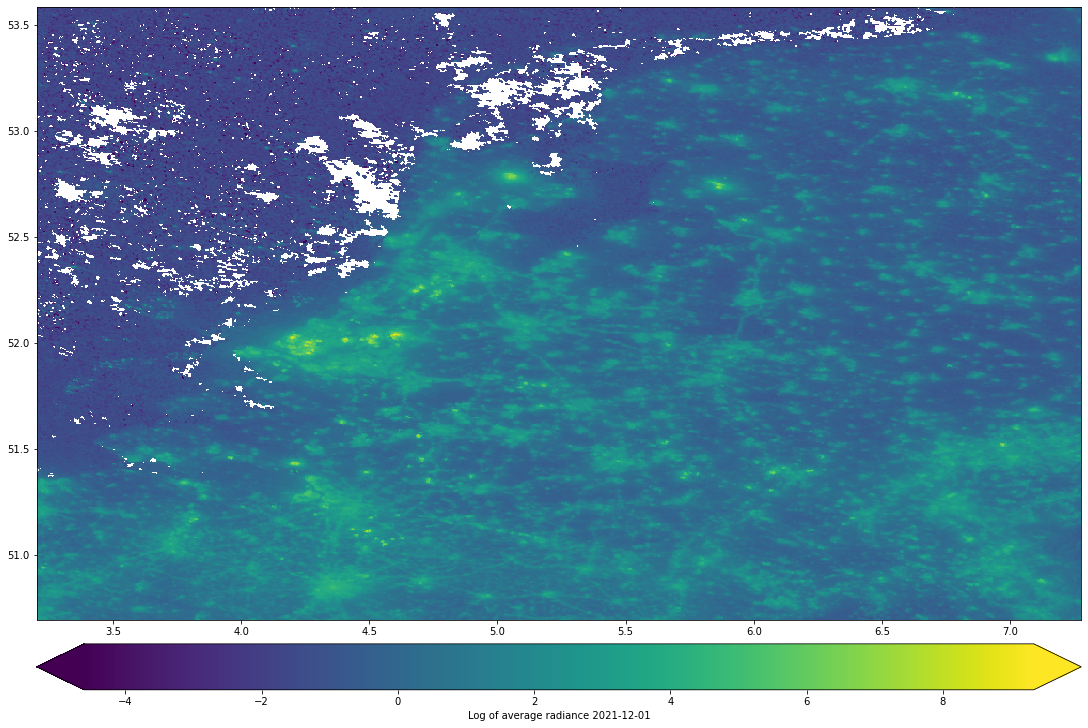

In [8]:
plt.figure();

lons = alan_nl['x']
lats = alan_nl['y']
avg_rad9h_log = xr.apply_ufunc(lambda x: np.log(x), alan_nl['avg_rad9h'])
time = pd.to_datetime(alan_nl.time.item())

fig, axs = plt.subplots(figsize=(15, 10), nrows=2, ncols=1,
                        gridspec_kw={'height_ratios': [20,1.5]},
                        constrained_layout=True);
rad9h = axs[0].pcolormesh(lons,lats,avg_rad9h_log,cmap='viridis');
cbar = fig.colorbar(rad9h,cax=axs[1], extend='both', orientation='horizontal');

cbar.set_label(f"Log of average radiance {time:%Y-%m-%d}");